# Support Vector Machines


In this notebook we gain some visual intuition on how Support Vector Machine (SVM) classifiers work with a dataset in 2 dimensions, and then build a spam classifier with SVMs!

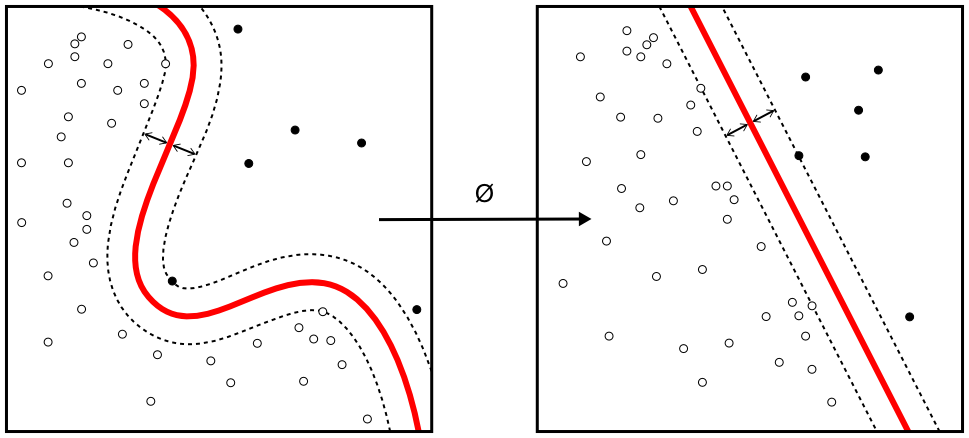

SVMs help us look at our training examples and learn a way to map them to a high-dimensional space so that we can separate different categories with boundaries that are as wide as possible (as in the image above). When a new example comes along, we can map it to that space and categorize it based on which side of the boundaries it falls on. 

This mapping is possible due to a [_kernel_](https://en.wikipedia.org/wiki/Kernel_method) function. This is the function that maps the examples into a high-dimensional space. Use of kernel functions are often called kernel tricks because we don't need to know the exact mapping of the examples into that space (which can be expensive to compute), but rather only the _similarity_ between those mappings (which can be cheaper to compute).

Even if this is all a bit fuzzy, SVMs are important to know and interesting to look at because they have been a [popular](https://www.quora.com/Why-did-SVM-become-more-popular-than-Logistic-Regression) [black-box](https://datascience.stackexchange.com/questions/711/are-support-vector-machines-still-considered-state-of-the-art-in-their-niche) [choice](https://www.researchgate.net/post/Can_we_say_that_SVM_is_the_best_classifier_to_date14) for machine learning practitioners.

You can find this code in modules [here](https://github.com/arturomp/coursera-machine-learning-in-python/tree/master/mlclass-ex6-004/mlclass-ex6), along with the files used.

This code was ported from Octave/Matlab to python and was part of the absolutely excellent [Machine Learning course](http://ml-class.org) by Stanford's [Andrew Ng](http://www.andrewng.org) on Coursera.

---

In [1]:
from __future__ import print_function
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import re
from nltk import PorterStemmer

## Visualization

We can start by visualizing our dataset

In [ ]:
def plotData(X, y):
    """Plots the data points X and y into a new figure """
    
    y = y.flatten()
    pos = y==1
    neg = y==0
    
    plt.plot(X[:,0][pos], X[:,1][pos], "k+", markersize=15, mew=3)
    plt.plot(X[:,0][neg], X[:,1][neg], "yo", markersize=15)

    # shorter but not as clear
    # plt.plot(X[:,0][pos], X[:,1][pos], 'k+', X[:,0][neg], X[:,1][neg], 'yo', markersize=15)

    plt.show()

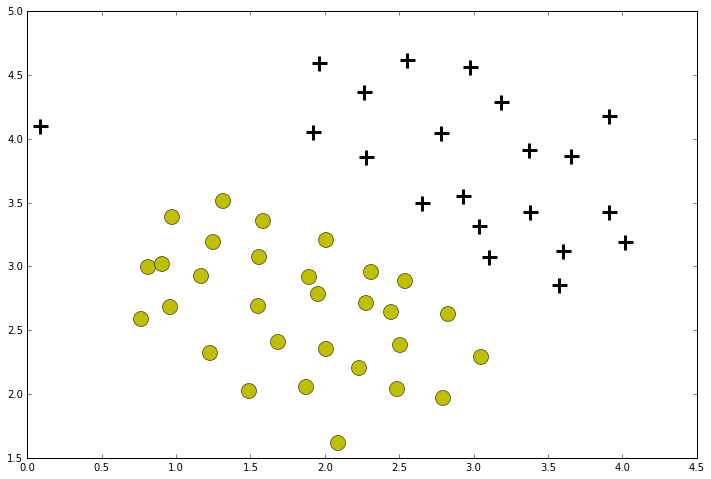

In [173]:
mat = scipy.io.loadmat('notebooks/svm-files/ex6data1.mat')
X = mat["X"]
y = mat["y"]

plt.figure(figsize=(12,8))
plotData(X, y)

## Linear kernel SVM

Now we can load ``svmTrain()``, a wrapper function to train a SVM. It's defined to accept other kernels moving forward.

In [5]:
def svmTrain(X, y, C, kernelFunction, tol=1e-3, max_passes=-1, sigma=0.1):
    """Trains an SVM classifier"""
    
    y = y.flatten()

    if kernelFunction == "gaussian_rbf":
        clf = svm.SVC(C = C, kernel="precomputed", tol=tol, max_iter=max_passes, verbose=2)
        return clf.fit(gaussianKernelGramMatrix(X,X, sigma=sigma), y)
    
    else: 
        clf = svm.SVC(C = C, kernel=kernelFunction, tol=tol, max_iter=max_passes, verbose=2)
        return clf.fit(X, y)        

We also define a function to visualize the linear boundary:

In [175]:
def visualizeBoundaryLinear(X, y, model):
    """Plots a linear decision boundary learned by the SVM"""
    
    plt.figure(figsize=(12,8))
    w = model.coef_[0]
    b = model.intercept_[0]
    xp = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yp = - (w[0] * xp + b) / w[1]

    plt.plot(xp, yp, 'b-')    
    plotData(X, y)

Then we can train a linear SVM and plot the decision boundary learned:

[LibSVM]

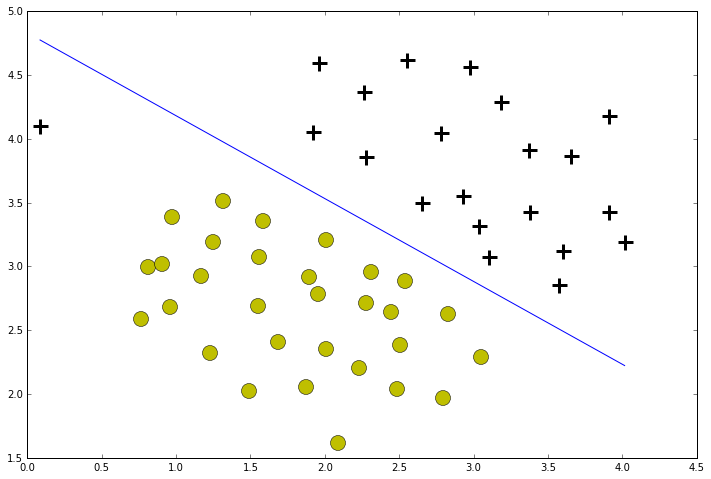

In [176]:
C = 1
model = svmTrain(X, y, C, "linear", 1e-3, 20)
visualizeBoundaryLinear(X, y, model)

We can also try a different value for ``C``, the parameter that tells the linear SVM "how much you want to avoid misclassifying each training example" [(as stated here)](https://stats.stackexchange.com/a/31067/19809). That is, it's a penalty for misclassified examples.

You can also see great visual representations the effects of low and high ``C`` values on different datasets [here](https://stats.stackexchange.com/a/159051/19809).


[LibSVM]

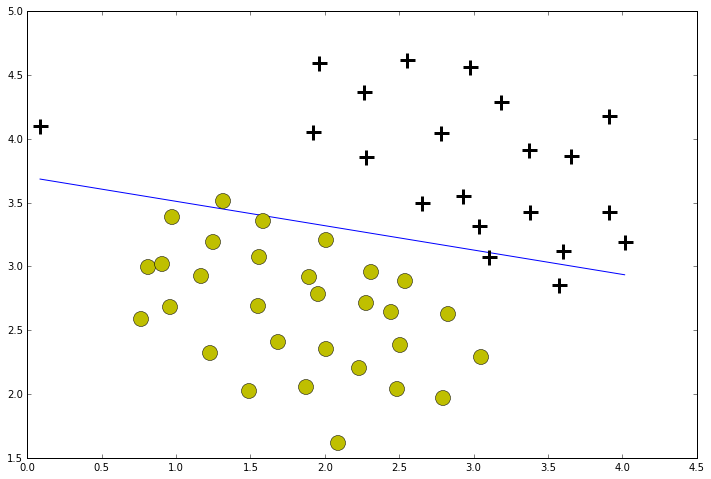

In [108]:
C = 100
model = svmTrain(X, y, C, "linear", 1e-3, 20)
visualizeBoundaryLinear(X, y, model)

We can see that, in an effort to accommodate the outlier around (0,4), the ``C=100`` boundary performs worse than with ``C=1``.

## Gaussian Kernel SVM

We extend our SVM capabilities by defining a Gaussian RBF kernel. In case you're curious, here's a more detailed explanation of the [difference between a Gaussian kernel and a Gaussian _RBF_ kernel](https://stats.stackexchange.com/questions/79192/gaussian-rbf-vs-gaussian-kernel). Roughly, the Gaussian RBF kernel used here helps us measure the distance or the similarity between a pair of examples. 

We use a ``sigma`` parameter that indicates how quickly the similarity metric decreases as two examples are further apart.

Using a custom kernel with [``sklearn.svm.SCV()``](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) was not as well documented as I'd hoped, so I put up an [answer about it](https://stackoverflow.com/a/38647546/583834) in Stack Overflow.

In [109]:
def gaussianKernel(x1, x2, sigma=0.1):
    """returns a (gaussian) radial basis function kernel between x1 and x2"""
    
    x1 = x1.flatten()
    x2 = x2.flatten()
    sim = np.exp(- np.sum( np.power((x1 - x2),2) ) / float( 2*(sigma**2) ) )

    return sim

def gaussianKernelGramMatrix(X1, X2, K_function=gaussianKernel, sigma=0.1):
    """(Pre)calculates Gram Matrix K"""

    gram_matrix = np.zeros((X1.shape[0], X2.shape[0]))
    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            gram_matrix[i, j] = K_function(x1, x2, sigma)
    return gram_matrix

We evaluate the implementation of ``gaussianKernel()``. The output should be about 0.324652.

In [110]:
x1 = np.array([1, 2, 1])
x2 = np.array([0, 4, -1])
sigma = 2
sim = gaussianKernel(x1, x2, sigma)

print("Gaussian Kernel between x1 =", x1, ", x2 =", x2, ", sigma =", sigma, ":\n{:f}".format(sim))

Gaussian Kernel between x1 = [1 2 1] , x2 = [ 0  4 -1] , sigma = 2 :
0.324652


### A more complex dataset

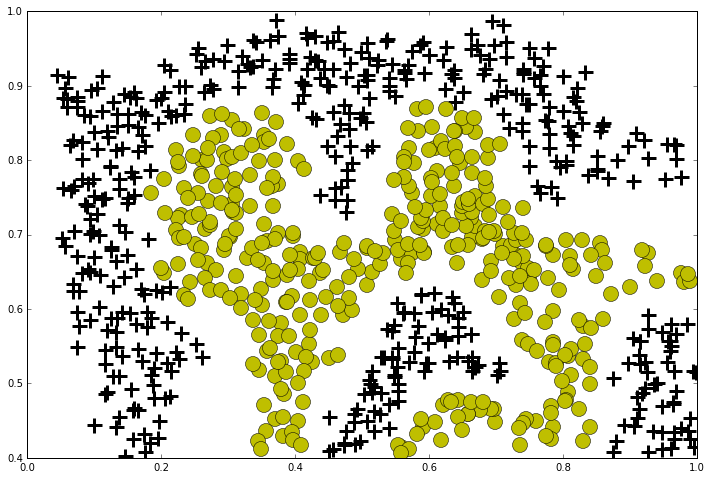

In [111]:
mat = scipy.io.loadmat('notebooks/svm-files/ex6data2.mat')
X = mat["X"]
y = mat["y"]

plt.figure(figsize=(12,8))
plotData(X, y)

In order to visualize the SVM-trained boundaries around the data categories, we define a new visualization function.

In [112]:
def visualizeBoundary(X, y, model, varargin=0):
    """Plots a non-linear decision boundary learned by the SVM"""
    
    plt.figure(figsize=(12,8))

    x1plot = np.linspace(X[:,0].min(), X[:,0].max(), 100).T
    x2plot = np.linspace(X[:,1].min(), X[:,1].max(), 100).T
    X1, X2 = np.meshgrid(x1plot, x2plot)
    vals = np.zeros(X1.shape)
    for i in xrange(X1.shape[1]):
       this_X = np.column_stack((X1[:, i], X2[:, i]))
       vals[:, i] = model.predict(gaussianKernelGramMatrix(this_X, X))

    plt.contour(X1, X2, vals, colors="blue", levels=[0,0], linewidth=5)
    
    plotData(X, y)

And now we can train a SVM with a Gaussian RBF kernel and visualize the boundaries it learns:

In [113]:
C = 1
sigma = 0.1

model = svmTrain(X, y, C, "gaussian_rbf", sigma=sigma)

[LibSVM]

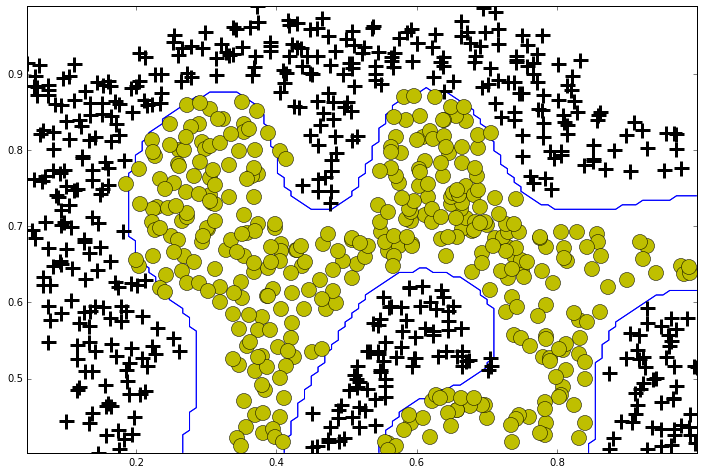

In [114]:
visualizeBoundary(X, y, model)

## Optimizing SVM parameters

Now we consider a third dataset

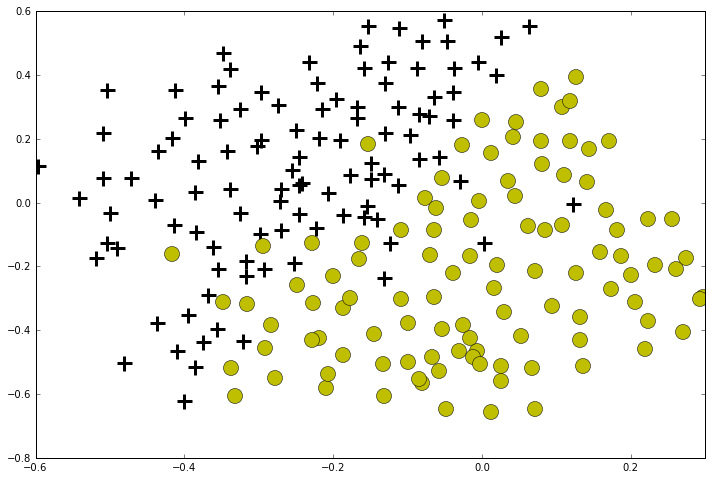

In [177]:
mat = scipy.io.loadmat('notebooks/svm-files/ex6data3.mat')
X = mat["X"]
y = mat["y"]

plt.figure(figsize=(12,8))
plotData(X, y)

We can try different parameters on a validation set to find a good fit for the trained boundaries. We define a function to explore the range {0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30} for ``C`` and ``sigma``.

In [178]:
def dataset3Params(X, y, Xval, yval):
    """returns optimal C and sigma found in the cross validation set"""
    
    predictionErrors = np.zeros((64,3))
    predictionsCounter = 0

    for sigma in [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]:
        for C in [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]:

            print(" trying C={:.2f}, sigma={:.2f},".format(C, sigma), end="...")
            
            model = svmTrain(X, y, C, "gaussian_rbf", sigma=sigma)

            predictions = model.predict(gaussianKernelGramMatrix(Xval, X))

            predictionErrors[predictionsCounter,0] = np.mean((predictions != yval).astype(int))

            predictionErrors[predictionsCounter,1] = C      
            predictionErrors[predictionsCounter,2] = sigma
            
            predictionsCounter = predictionsCounter + 1

    print()
    
    # sort ndarray by first column, from https://stackoverflow.com/a/2828121/583834
    predictionErrors = predictionErrors[predictionErrors[:,0].argsort()]
    
    print('\t# Pred. error\tsigma\tC\n')
    for i in xrange(predictionErrors.shape[0]):
        pred_error, sigma, C, = predictionErrors[i][:]
        print('  \t{:f}\t{:.2f}\t{:.2f}'.format(pred_error, sigma, C))

    C     = predictionErrors[0,1]
    sigma = predictionErrors[0,2]

    return C, sigma

And we run it to find the optimal values of ``C`` and ``sigma``.

In [179]:
Xval = mat["Xval"]
yval = mat["yval"]

C, sigma = dataset3Params(X, y, Xval, yval)
print("Best parameters are C={:.2f}, sigma={:.2f}".format(C, sigma))

 trying C=0.01, sigma=0.01,...[LibSVM] trying C=0.03, sigma=0.01,...[LibSVM] trying C=0.10, sigma=0.01,...[LibSVM] trying C=0.30, sigma=0.01,...[LibSVM] trying C=1.00, sigma=0.01,...[LibSVM] trying C=3.00, sigma=0.01,...[LibSVM] trying C=10.00, sigma=0.01,...[LibSVM] trying C=30.00, sigma=0.01,...[LibSVM] trying C=0.01, sigma=0.03,...[LibSVM] trying C=0.03, sigma=0.03,...[LibSVM] trying C=0.10, sigma=0.03,...[LibSVM] trying C=0.30, sigma=0.03,...[LibSVM] trying C=1.00, sigma=0.03,...[LibSVM] trying C=3.00, sigma=0.03,...[LibSVM] trying C=10.00, sigma=0.03,...[LibSVM] trying C=30.00, sigma=0.03,...[LibSVM] trying C=0.01, sigma=0.10,...[LibSVM] trying C=0.03, sigma=0.10,...[LibSVM] trying C=0.10, sigma=0.10,...[LibSVM] trying C=0.30, sigma=0.10,...[LibSVM] trying C=1.00, sigma=0.10,...[LibSVM] trying C=3.00, sigma=0.10,...[LibSVM] trying C=10.00, sigma=0.10,...[LibSVM] trying C=30.00, sigma=0.10,...[LibSVM] trying C=0.01, sigma=0.30,...[LibSVM] trying C=0.03, sigma=0.30,...[LibSVM] tryin

Finally, we use these parameters to train a SVM model and visualize its boundaries.

[LibSVM]

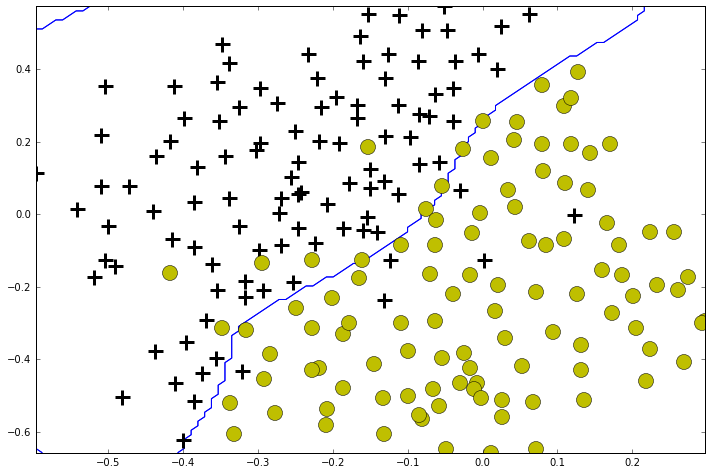

In [180]:
model = svmTrain(X, y, C, "gaussian_rbf", sigma=sigma)
visualizeBoundary(X, y, model)

# Spam classifier

Now that we've applied SVMs to datasets and tuned their parameters, we can apply them to a more real-world application: spam classification (or curation ;).

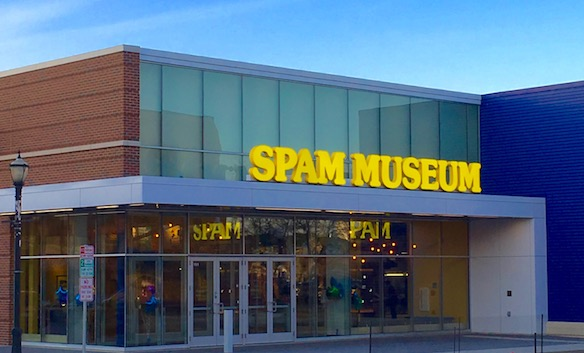


With a trained SVM we'll determine whether an unseen email is spam (``y=1``) or not spam (``y=0``).

## Vectorizing emails

In order to turn email text into training data that we can use in an SVM, we first need to establish a pipeline to turn each of the emails into a feature vector.

The data we'll be working with comes from the [SpamAssassin Public Corpus](http://csmining.org/index.php/spam-assassin-datasets.html) and contains only the body of the email (without the headers).

Doing some data exploration can help us see how we can process these emails to eventually vectorize them

In [6]:
def readFile(filename):
    """reads a file and returns its entire contents """
    try:
        with open(filename, 'r') as openFile:
            file_contents = openFile.read()
    except:
        file_contents = ''
        print('Unable to open {:s}'.format(filename))

    return file_contents

In [18]:
file_contents = readFile('notebooks/svm-files/emailSample1.txt')
print(file_contents)

> Anyone knows how much it costs to host a web portal ?
>
Well, it depends on how many visitors you're expecting.
This can be anywhere from less than 10 bucks a month to a couple of $100. 
You should checkout http://www.rackspace.com/ or perhaps Amazon EC2 
if youre running something big..

To unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com




### Feature engineering

Items like email addresses, URLs, numbers and dollar amounts can be normalized. Different emails make reference to distinct specific addresses and amounts, but for our purposes it makes sense to treat them all as the same kind of entity. 

For instance, we can replace all URLs for the string ``httpaddr`` to indicate that the email had a URL at that location. This makes it possible for the presence or absence of a URL to be a feature to be used by the spam classifier, instead of having a feature for every URL possible. Given that spam emails tend to use odd, unique-looking URLs, we can save a lot of features with normalization.

Normalizing text this way usually has the effect of [improving classifier performance](https://nlp.stanford.edu/IR-book/html/htmledition/features-for-text-1.html).

Choosing which words we use in the classifier is also important. For this exercise, the most frequent words have already been selected and are included in ``vocab.txt``. Rare words that occur only in a few emails could throw the classifier off by causing it to overfit. The vocabulary list was chosen by selecting words with a minimum frequency of 100 across the whole SpamAssassin corpus. Our feature set consists of only 1899 words, but in the real world we can easily have vocabulary lists of tens of thousands of tokens.

See the comments on the preprocessing code below to see more details on how each email is processed and normalized.

In [2]:
def getVocabList():
    """reads the fixed vocabulary list in vocab.txt and returns a
    cell array of the words
    """
    
    with open('notebooks/svm-files/vocab.txt', 'r') as vocabFile:
        vocabList = {}
        for line in vocabFile.readlines():
            i, word = line.split()
            vocabList[word] = int(i)

    return vocabList

def processEmail(email_contents, verbose=True):
    """preprocesses a the body of an email and
    returns a list of word_indices 
    """
    vocabList = getVocabList()

    # Init return value
    word_indices = []

    # ========================== Preprocess Email ===========================

    # Find the Headers ( \n\n and remove )
    # Uncomment the following lines if you are working with raw emails with the
    # full headers

    # hdrstart = email_contents.find("\n\n")
    # if hdrstart:
    #     email_contents = email_contents[hdrstart:]

    # Lower case
    email_contents = email_contents.lower()

    # Strip all HTML
    # Looks for any expression that 
    # - starts with < and ends with >, &
    # - does not have any < or > in the tag 
    # and replace it with a space 
    email_contents = re.sub('<[^<>]+>', ' ', email_contents)

    # Handle Numbers
    # Look for one or more characters between 0-9 and replace it with 'number'
    email_contents = re.sub('[0-9]+', 'number', email_contents)

    # Handle URLS
    # Look for strings starting with http:// or https://
    # and replace with 'httpaddr'
    email_contents = re.sub('(http|https)://[^\s]*', 'httpaddr', email_contents)

    # Handle Email Addresses
    # Look for strings with @ in the middle
    # and replace with 'emailaddr'
    email_contents = re.sub('[^\s]+@[^\s]+', 'emailaddr', email_contents)

    # Handle $ sign
    # replace with 'dollar'
    email_contents = re.sub('[$]+', 'dollar', email_contents)


    # Output the email to screen as well
    if verbose: print('\n==== Processed Email ====\n\n')

    l = 0

    # Split and also get rid of any punctuation
    # regex may need further debugging...
    email_contents = re.split(r'[@$/#.-:&\*\+=\[\]?!(){},\'\'\">_<;%\s\n\r\t]+', email_contents)

    for token in email_contents:

        # Remove any non alphanumeric characters
        token = re.sub('[^a-zA-Z0-9]', '', token)

        # Stem the word 
        token = PorterStemmer().stem_word(token.strip())

        # Skip the word if it is too short
        if len(token) < 1:
           continue

        # Look up the word in the dictionary and add to word_indices if found
        idx = vocabList[token] if token in vocabList else 0

        # only add entries which are in vocabList
        #   i.e. those with ind ~= 0, 
        #        given that ind is assigned 0 if str is not found in vocabList
        if idx > 0:
            word_indices.append(idx)

        # Print to screen, ensuring that the output lines are not too long
        if verbose:
            if l + len(token) + 1 > 78:
                print("")
                l = 0
            print('{:s}'.format(token)),
            l = l + len(token) + 1

    # Print footer
    if verbose: print('\n\n=========================\n')

    return word_indices

We can compare the email before processing...

---

In [55]:
file_contents = readFile('notebooks/svm-files/emailSample1.txt')
print(file_contents)

> Anyone knows how much it costs to host a web portal ?
>
Well, it depends on how many visitors you're expecting.
This can be anywhere from less than 10 bucks a month to a couple of $100. 
You should checkout http://www.rackspace.com/ or perhaps Amazon EC2 
if youre running something big..

To unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com




---

...and after processing, where we end up with a list of words.

In [56]:
file_contents = readFile('notebooks/svm-files/emailSample1.txt')
word_indices  = processEmail(file_contents)

print('Word Indices: ')
print(' {:s}'.format(word_indices))


==== Processed Email ====


anyon
know
how
much
it
cost
to
host
a
web
portal
well
it
depend
on
how
mani

visitor
you
re
expect
thi
can
be
anywher
from
less
than
number
buck
a
month

to
a
coupl
of
dollarnumb
you
should
checkout
httpaddr
or
perhap
amazon
ecnumb

if
your
run
someth
big
to
unsubscrib
yourself
from
thi
mail
list
send
an

email
to
emailaddr



Word Indices: 
 [86, 916, 794, 1077, 883, 370, 1699, 790, 1822, 1831, 883, 431, 1171, 794, 1002, 1893, 1364, 592, 1676, 238, 162, 89, 688, 945, 1663, 1120, 1062, 1699, 375, 1162, 479, 1893, 1510, 799, 1182, 1237, 810, 1895, 1440, 1547, 181, 1699, 1758, 1896, 688, 1676, 992, 961, 1477, 71, 530, 1699, 531]


### Feature extraction

From here, we can now turn emails into vectors in $\mathbb{R}^{n}$ (vectors with $n$ terms or $n$ dimensions), where $n$ is the size of our vocabulary, 1899.

Each vector derived from an email will represent the presence in the email (1) or absence from the email (0) of each of the words of the vocabulary.

``emailFeatures()`` below extracts these features from emails.

In [3]:
def emailFeatures(word_indices):
    """takes in a word_indices vector and produces a feature vector
    from the word indices"""
    n = 1899
    x = np.zeros((n, 1))
    for idx in word_indices:
        x[idx] = 1
    
    return x

Turning the email above into a vector now consists of extracting its features! Below we can see how many elements of its feature vector are nonzero.

In [7]:
file_contents = readFile('notebooks/svm-files/emailSample1.txt')
word_indices  = processEmail(file_contents, verbose=False)
features      = emailFeatures(word_indices)

print('Length of feature vector: {:d}'.format( len(features) ) )
print('Number of non-zero entries: {:d}'.format( np.sum(features > 0) ) )

Length of feature vector: 1899
Number of non-zero entries: 45


Of course, 45 is also the number of unique word indices in the list resulting from email preprocessing.

## Training a spam classifier

With a pipeline from email to feature vector established, we can work with the (previously preprocessed) emails feature vectors in the ``spamTrain.mat`` file. 

With these email feature vectors we will train a SVM spam classifier model.

In [8]:
mat = scipy.io.loadmat('notebooks/svm-files/spamTrain.mat')
X = mat["X"]
y = mat["y"]

print('Training Linear SVM Spam Classification (this may take 1 to 2 minutes)...')

C = 0.1
model = svmTrain(X, y, C, "linear")

Training Linear SVM Spam Classification (this may take 1 to 2 minutes)...
[LibSVM]

Then we make predictions on the training data from the model and assess their accuracy.

In [9]:
p = model.predict(X)
print('Training Accuracy: {:f}'.format( np.mean((p == y.flatten()).astype(int)) * 100 ))

Training Accuracy: 99.825000


And we evaluate the model on unseen test data.

In [10]:
mat = scipy.io.loadmat('notebooks/svm-files/spamTest.mat')
Xtest = mat["Xtest"]
ytest = mat["ytest"]

print('Evaluating the trained Linear SVM on a test set ...')

p = model.predict(Xtest)
print('Test Accuracy: {:f}'.format( np.mean((p == ytest.flatten()).astype(int)) * 100 ))

Evaluating the trained Linear SVM on a test set ...
Test Accuracy: 98.900000


## Understanding a spam classifier

One advantage of using the linear kernel for our SVM is that we can peek inside the weights to better understand how it discriminates spam from non-spam (ham?) email.

The following are the words that the classifier has most strongly linked to a positive spam classification.

In [11]:
w = model.coef_[0]
indices = w.argsort()[::-1][:15]
vocabList = sorted(getVocabList().keys())

print('\nTop predictors of spam: \n');
for idx in indices: 
    print( ' {:s} ({:f}) '.format( vocabList[idx], float(w[idx]) ) )


Top predictors of spam: 

 our (0.500614) 
 click (0.465916) 
 remov (0.422869) 
 guarante (0.383622) 
 visit (0.367710) 
 basenumb (0.345064) 
 dollar (0.323632) 
 will (0.269724) 
 price (0.267298) 
 pleas (0.261169) 
 most (0.257298) 
 nbsp (0.253941) 
 lo (0.253467) 
 ga (0.248297) 
 hour (0.246404) 


## More spam! (Maybe!)

Since we established a pipeline to process emails to determine whether they're spam or not, it makes sense to use it for at least a few more examples.

Below we read a few normal and spam emails and show how the model classifies them.

In [12]:
filename = 'notebooks/svm-files/spamSample1.txt'

# Read and predict
file_contents = readFile(filename)
word_indices  = processEmail(file_contents, verbose=False)
x             = emailFeatures(word_indices)
p = model.predict(x.reshape(1, -1))

print('\nProcessed {:s}\n\nSpam Classification: {:s}\n'.format(filename, p))


Processed notebooks/svm-files/spamSample1.txt

Spam Classification: [0]



Oops! 💩

In [13]:
filename = 'notebooks/svm-files/spamSample2.txt'

# Read and predict
file_contents = readFile(filename)
word_indices  = processEmail(file_contents, verbose=False)
x             = emailFeatures(word_indices)
p = model.predict(x.reshape(1, -1))

print('\nProcessed {:s}\n\nSpam Classification: {:s}\n'.format(filename, p))


Processed notebooks/svm-files/spamSample2.txt

Spam Classification: [1]



🙌

In [14]:
filename = 'notebooks/svm-files/emailSample1.txt'

# Read and predict
file_contents = readFile(filename)
word_indices  = processEmail(file_contents, verbose=False)
x             = emailFeatures(word_indices)
p = model.predict(x.reshape(1, -1))

print('\nProcessed {:s}\n\nSpam Classification: {:s}\n'.format(filename, p))


Processed notebooks/svm-files/emailSample1.txt

Spam Classification: [0]



👍

In [15]:
filename = 'notebooks/svm-files/emailSample2.txt'

# Read and predict
file_contents = readFile(filename)
word_indices  = processEmail(file_contents, verbose=False)
x             = emailFeatures(word_indices)
p = model.predict(x.reshape(1, -1))

print('\nProcessed {:s}\n\nSpam Classification: {:s}\n'.format(filename, p))


Processed notebooks/svm-files/emailSample2.txt

Spam Classification: [0]



👏